<a href="https://colab.research.google.com/github/junlynli/Variational-Autoencoders/blob/main/Copy_of_Probabilistic_ML_(Winter_2022)_Homework_4_Variational_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic ML (Winter 2022): Homework 4: Variational Autoencoders

- **Deadline**: April 8th, at 23:59.
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

## Version 2022/03/31
Q1.4 and Q2.1 key --> rng in objective fnc

March 31: Removed from Q3 the text "On a single plot, show the isocontours of the joint distribution $p(z, \text{top half of image x})$, and the optimized approximate posterior $q_\phi(z | \text{top half of image x})$."

## Your Info

- **Name: Jun Li**
- **Student Number: 1004410817**
- **Collaborators:**

## Question 1: Warm up with synthetic data - 30 points

In this question, we will train a VAE on a synhetic data which resembles spirals in 2d. This question is intended to provided you some debugging tools for the next question where you work on MNIST dataset. In both of the questions, we will perform amortized inference with VAEs.

In [ ]:
from jax import jit, grad, value_and_grad, lax, vmap, random
import jax.numpy as np
import jax.random
from jax.nn import softplus
import jax.nn.initializers as nn_init
from jax.experimental import optimizers, stax
from jax.experimental.stax import serial, parallel, Dense, Relu, FanOut, FanInSum, Softplus, Identity, Tanh
from jax.scipy.special import logsumexp
from jax.tree_util import register_pytree_node

import tensorflow_probability as tfp
import tensorflow_probability.substrates.jax.distributions as dists

from jax.config import config 
config.update("jax_debug_nans", True)

import matplotlib.pyplot as plt
from tqdm.auto import trange
from jax.scipy.stats import norm
from functools import partial

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


**1.1) [0 points]** The following functions can be used to visualize the output.

In [ ]:
# Helper functions
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-3, 3], ylimits=[-3, 3], numticks=101, cmap="summer"):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    zs = func(X.ravel(), Y.ravel())
    Z = zs.reshape(X.shape)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([3, -3], [3, -3], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()


**1.2) [0 points]** Below function generates the synthetic spiral data.

In [ ]:
# Code to generate the pinwheel dataset.
# Taken from [Johnson et al (2016)], updated by Zhao & Linderman.
def make_pinwheel_data(rng, radial_std, tangential_std, num_classes, num_per_class, rate):
    rads = np.linspace(0, 2*np.pi, num_classes, endpoint=False)

    features = jax.random.normal(rng, (num_classes*num_per_class, 2)) \
        * np.array([radial_std, tangential_std])
    features = features.at[:, 0].add(1.0)
    labels = np.repeat(np.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * np.exp(features[:,0])
    rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = np.reshape(rotations.T, (-1, 2, 2))

    return jax.random.permutation(rng,labels), jax.random.permutation(rng, np.einsum('ti,tij->tj', features, rotations))

We visualize the 2d data generated from the above function. Notice that there are 3 clusters in the input space, each colored with a different color. The VAE will not see the cluster assignments, but we hope to recover this structure in the latent space.

(-1.7937924802303313,
 1.8979793727397918,
 -2.059972715377808,
 2.3492221355438234)

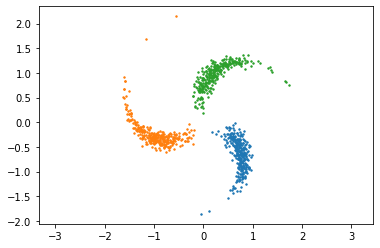

In [ ]:
num_clusters = 3           
samples_per_cluster = 300
rng = jax.random.PRNGKey(0)
labels, data = make_pinwheel_data(rng, 0.3, 0.1, num_clusters, samples_per_cluster, 0.25)

for k in range(num_clusters):
    plt.scatter(data[labels == k, 0], data[labels == k, 1], s=2)

plt.axis("equal")

**1.3) [20 points]** Implement the missing lines in the below code, to complete
the $\texttt{elbo}$ function for a variational autoencoder.

You can write all your functions to take a single datapoint, and just use vmap() to allow it to take batches.  For instance, this is done for you in the $\texttt{batch_elbo}()$ function below.

You can and should use the same code for both the spiral dataset and MNIST.  The spiral dataset and an example encoder / decoder is provided just to help you debug, and as a template for the MNIST VAE.


In [ ]:
# Generic VAE functions.

def log_prior(z): 
    return np.sum(norm.logpdf(z, 0.0, 1.0), axis=-1)

def diag_gaussian_sample(rng, mean, log_std): 
  # Take a single sample from a diagonal multivariate Gaussian.
  return mean + np.exp(log_std) * random.normal(rng, mean.shape)

def diag_gaussian_logpdf(x, mean, log_std):
  # Evaluate a single point on a diagonal multivariate Gaussian.
  return np.sum(vmap(norm.logpdf)(x, mean, np.exp(log_std)))

def elbo(  # Single-sample Monte Carlo estimate of the variational lower bound.
    recognition_net,    # takes recognition_params and a datapoint, outputs mean and log_std of size latent_dim, i.e. log q(z|x)
    log_joint,          # takes model_params and a vector of size latent_dim and a datapoint, outputs unnormalized log joint, i.e. log p(x,z)
    recognition_params, # a.k.a. phi
    model_params,       # a.k.a. theta
    datapoint,          # a.k.a. x
    rng):

  q_params = recognition_net(recognition_params, datapoint)
  sample = diag_gaussian_sample(rng, *q_params)
  log_joint_value = log_joint(model_params, sample, datapoint)
  log_post_value = diag_gaussian_logpdf(sample, *q_params)
  elbo_hat = np.mean(log_joint_value - log_post_value)
  return elbo_hat

def batch_elbo(recognition_net, log_joint, recognition_params,
               model_params, data, rng):
  # Average ELBO estimate over a batch of random samples.
  batch_size = data.shape[0]
  rngs = random.split(rng, batch_size)
  vectorized_elbo = vmap(partial(elbo, recognition_net, log_joint,
                                 recognition_params, model_params),
                         in_axes=(0, 0))
  return np.mean(vectorized_elbo(data, rngs))


**1.4) [0 points]** The below code trains a VAE where the encoder and decoder are both neural networks. The parameters are specified in the starter code.  You don't need to do anything here, this is just to help you debug.

In [ ]:
# Define a VAE for the spiral dataset.

data_dimension = 2
latent_dimension = 2
key = random.PRNGKey(0)

# Define the recognition network.
# We implement the functions as a split output of a 1-layer MLP
# https://github.com/google/jax/blob/master/jax/experimental/README.md#neural-net-building-with-stax
init_recognize, recognition_net = serial(
    Dense(100), 
    Relu,
    Dense(50), 
    Relu,
    FanOut(2),
    parallel(
        Dense(latent_dimension),   # Output mean of q(z)
        Dense(latent_dimension)    # Output log_std of q(z)
        )
    )
_, init_recognition_params = init_recognize(rng, input_shape=(data_dimension,))

# Define the decoder network.
# Note that it has two outputs, a mean and a variance, because 
# this model has a Gaussian likelihood p(x|z).
init_decoder, decoder = serial(
    Dense(100), 
    Relu,
    Dense(50), 
    Relu,
    FanOut(2),
    parallel(
        Dense(data_dimension),    # Output mean of p(x|z)
        Dense(data_dimension)     # Output log_std of p(x|z).
        )
    )
_, init_decoder_params = init_decoder(rng, input_shape=(latent_dimension,))

# Set up log likelihood function.
def log_likelihood(decoder_params, latent, datapoint):
  mean, log_std = decoder(decoder_params, latent)
  return diag_gaussian_logpdf(datapoint, mean,
                              np.log(0.1) + 0. * log_std)  # Note: we are cheating here and using a fixed noise variance to make optimization more stable.

def log_joint(decoder_params, latent, datapoint):
  return log_prior(latent) + log_likelihood(decoder_params, latent, datapoint)

# Run optimization
optimizer=optimizers.adam
optimizer_kwargs=dict(step_size=1e-3)
n_iters = 2000
minibatch_size = 300

opt_init, opt_update, get_params = optimizer(**optimizer_kwargs)
opt_state = opt_init((init_recognition_params, init_decoder_params))

def objective(params, t):  # The loss function to be minimized.
  rng = random.PRNGKey(t)
  minibatch_ixs = random.choice(rng, data.shape[0], (minibatch_size,))
  minibatch = data[minibatch_ixs, :]
  recognition_params, decoder_params = params
  return -batch_elbo(
    recognition_net,
    log_joint,
    recognition_params,  # a.k.a. phi
    decoder_params,      # a.k.a. theta
    minibatch,
    rng)

def callback(params, t):
  if t % 100 == 0:
    print("Iteration {} lower bound {}".format(t, -objective(params, t)))

@jit
def update(i, opt_state):
    params = get_params(opt_state) 
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)

recognition_params, decoder_params = params

Optimizing variational parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0 lower bound -53.33385467529297
Iteration 100 lower bound -3.6101741790771484
Iteration 200 lower bound -2.0128462314605713
Iteration 300 lower bound -2.1104629039764404
Iteration 400 lower bound -1.7528504133224487
Iteration 500 lower bound -1.5729666948318481
Iteration 600 lower bound -1.5721544027328491
Iteration 700 lower bound -1.5243772268295288
Iteration 800 lower bound -1.4194494485855103
Iteration 900 lower bound -1.4143906831741333
Iteration 1000 lower bound -1.2287778854370117
Iteration 1100 lower bound -1.357613444328308
Iteration 1200 lower bound -1.0730394124984741
Iteration 1300 lower bound -1.3104288578033447
Iteration 1400 lower bound -1.3259432315826416
Iteration 1500 lower bound -1.216987133026123
Iteration 1600 lower bound -1.2964695692062378
Iteration 1700 lower bound -1.1951866149902344
Iteration 1800 lower bound -1.244471788406372
Iteration 1900 lower bound -1.07912015914917


1.5) [5 points] In this part, we visualize how the data looks like in the latent space. We simply use the trained recognition network (the encoder) to map each input to latent space.

The result should look something like:

![](https://drive.google.com/uc?id=1o1mlRp974jdDONZl8Gdz3FceqrMS--6E)

Text(0.5, 0, 'latent dimension 2')

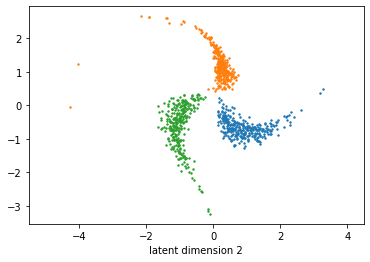

In [ ]:
# Show the means of the encoded data in a 2D latent space.
# Don't worry if this doesn't look much like a Gaussian.

for k in range(num_clusters):
  cur_data = data[labels == k, :]
  # extract mean from the trained recognition net
  transformed = recognition_net(recognition_params, cur_data)[0]
  plt.scatter(transformed[:, 0], transformed[:, 1], s=2)

plt.axis("equal")
plt.xlabel("latent dimension 1")
plt.xlabel("latent dimension 2")

**1.6) [5 points]** Using the decoder and the generative model we just trained, we can generate new data. For this, we simply generate 1000 latent variables in the latent space from the prior and pass it through the decoder network.

You shouldn't expect this to match the data exactly, just to get the overall shape and number of clusters roughly correct.  Counterintuitively, the larger and richer MNIST data is easier to fit than this toy dataset.

The result should look something like:

![](https://drive.google.com/uc?id=1AI691z1q82-zwbLlBv1-4UiO08wwEifx)

(-2.336806219816208, 1.490620893239975, -1.92169548869133, 1.6214748799800873)

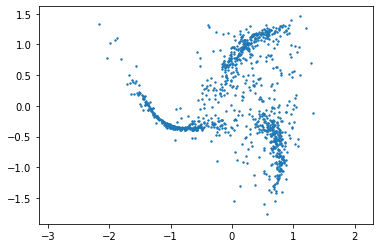

In [ ]:
# Sample data from the trained generative model to see if it
# roughly matches the data.  # Note: This doesn't add the likelihood noise,
# although it should if we want it to match the data.

num_samples = 1000
# sample from the standard normal prior
samples =  jax.random.normal(rng, shape=(num_samples, 2))
# extract mean from the trained decoder with samples from the prior 
transformed = decoder(decoder_params, samples)[0]
plt.scatter(transformed[:, 0], transformed[:, 1], s=2)
plt.axis("equal")

**1.7) [0 points]** Here's a debugging tool only available when both the latent space and the data are both 2-dimensional.  We can show the function being learned by the encoder by showing how it warps a 2D grid into the latent space.

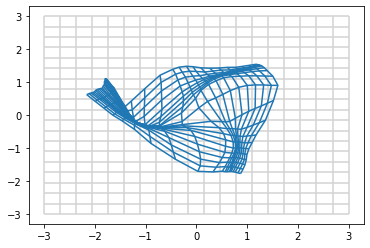

In [ ]:
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

def f(x,y):
  return decoder(decoder_params, np.array([x, y]))
f = vmap(f, in_axes=(0,0))
f = vmap(f, in_axes=(0,0))

fig, ax = plt.subplots()

grid_x,grid_y = np.meshgrid(np.linspace(-3,3,20),np.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
plot_grid(distx[:, :, 0], distx[:, :, 1], ax=ax, color="C0")

plt.show()

**1.8) [0 points]** Here, we show the function being learned by the decoder by showing how it warps a 2D grid into the observed space.



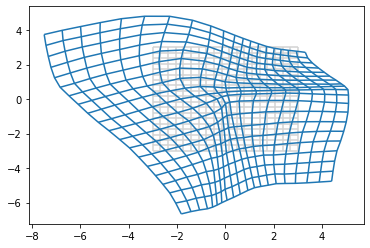

In [ ]:
def f(x,y):
  return recognition_net(recognition_params, np.array([x, y]))
f = vmap(f, in_axes=(0,0))
f = vmap(f, in_axes=(0,0))

fig, ax = plt.subplots()

grid_x,grid_y = np.meshgrid(np.linspace(-3,3,20),np.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
plot_grid(distx[:, :, 0], distx[:, :, 1], ax=ax, color="C0")

plt.show()

# Question 2 - 45 points

In this question, we will implement and investigate the Variational Autoencoder on binarized MNIST digits, as introduced by the paper [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf) by Kingma and Welling (2013).


**MNIST data**: Each datapoint in the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) is a 28x28 grayscale image (i.e. pixels are values between 0 and 1) of a handwritten digit in $\{0 \dots 9\}$, and a label indicating which number.

The below code contains a function that downloads the MNIST data set and another one that can plot multiple images.


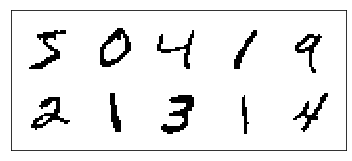

In [ ]:
# Load MNIST data
import os
import gzip
import struct
import array
import matplotlib.image
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def mnist():
    base_url = 'http://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')

    return train_images, train_labels, test_images[:1000], test_labels[:1000]


def load_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(np.array(x.shape[1:]))))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

N_data, train_images, train_labels, test_images, test_labels = load_mnist()

import numpy as onp
def plot_images(images, ims_per_row=5, padding=5, digit_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = onp.int32(onp.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = onp.full(((digit_dimensions[0] + padding) * N_rows + padding,
                             (digit_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], digit_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + digit_dimensions[0]) * row_ix
        col_start = padding + (padding + digit_dimensions[1]) * col_ix
        concat_images[row_start: row_start + digit_dimensions[0],
                      col_start: col_start + digit_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(onp.array([]))
        plt.yticks(onp.array([]))
    
    plt.plot()

plot_images(train_images[:10, :])

**2.1) [20 pts]** The model is as follows.


*   **Prior:** The prior over each digit's latent representation is a multivariate standard normal distribution. For all questions, we'll set the dimension of the latent space to 2.
A larger latent dimension would provide a more powerful model, but for this assignment we'll use a two-dimensional latent space to make visualization and debugging easier.


*   **Likelihood:** Given the latent representation $z$ for an image, the distribution over all 784 pixels in the image is given by a product of independent Bernoullis, whose means are given by the output of a neural network $f_\theta(z)$:
$$p(x|z, \theta) = \prod_{d=1}^{784} \operatorname{Ber}(x_d|f_\theta(z)_d)$$
The neural network $f_\theta$ is called the decoder, and its parameters $\theta$ will be optimized to fit the data.

Implement the missing lines in the below code, to complete
the functions:
1.   $\texttt{log_likelihood}$: Log-likelihood of the above model.
2.   $\texttt{log_joint}$: Joint log-likelihood of data and latent variables.
3.   $\texttt{objective}$: You will use the elbo function you wrote in the previous question.

Report the final ELBO. 

In [ ]:
# Define a specific VAE for MNIST

data_dimension = 28*28
latent_dimension = 2
key = random.PRNGKey(0)

# Define the recognition network.
# We implement the functions as a split output of a 1-layer MLP
# https://github.com/google/jax/blob/master/jax/experimental/README.md#neural-net-building-with-stax
init_recognize, recognition_net = serial(
    Dense(150),
    Relu,
    Dense(50),
    Relu,
    FanOut(2),
    parallel(
        Dense(latent_dimension),   # Output mean of q(z)
        Dense(latent_dimension)    # Output log_std of q(z)
        )
    )
_, init_recognition_params = init_recognize(rng, input_shape=(data_dimension,)) 


# Define the decoder network.
init_decoder, decoder = serial(
    Dense(150),
    Relu,
    Dense(50),
    Relu,
    Dense(data_dimension),    # Output logit of Ber(x|z)
)
_, init_decoder_params = init_decoder(rng, input_shape=(latent_dimension,))


# Set up log likelihood function.
def bernoulli_logpdf(logits, x):
  """Bernoulli log pdf of data x given logits."""
  return -np.sum(np.logaddexp(0., np.where(x, -1., 1.) * logits))

def log_likelihood(decoder_params, latent, datapoint): 
  logits = decoder(decoder_params, latent)
  return bernoulli_logpdf(logits, datapoint)

def log_joint(decoder_params, latent, datapoint):
  return log_prior(latent) + log_likelihood(decoder_params, latent, datapoint)

# Run optimization
optimizer=optimizers.adam
optimizer_kwargs=dict(step_size=1e-2)
n_iters = 5000
minibatch_size = 200

opt_init, opt_update, get_params = optimizer(**optimizer_kwargs)
opt_state = opt_init((init_recognition_params, init_decoder_params))

def objective(params, t):  # The loss function to be minimized.  
  rng = random.PRNGKey(t)
  minibatch_ixs = random.choice(rng, train_images.shape[0], (minibatch_size,))
  minibatch = train_images[minibatch_ixs, :]
  recognition_params, decoder_params = params
  return -batch_elbo(
    recognition_net,
    log_joint,
    recognition_params,  # a.k.a. phi
    decoder_params,      # a.k.a. theta
    minibatch,
    rng)

def callback(params, t):
  if t % 100 == 0:
    print("Iteration {} lower bound {}".format(t, -objective(params, t)))

@jit
def update(i, opt_state):
    params = get_params(opt_state) 
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)

recognition_params, decoder_params = params

Optimizing variational parameters...


  0%|          | 0/5000 [00:00<?, ?it/s]

Iteration 0 lower bound -524.9828491210938
Iteration 100 lower bound -180.47645568847656
Iteration 200 lower bound -169.67877197265625
Iteration 300 lower bound -162.68885803222656
Iteration 400 lower bound -165.4884490966797
Iteration 500 lower bound -156.73109436035156
Iteration 600 lower bound -152.35374450683594
Iteration 700 lower bound -156.24057006835938
Iteration 800 lower bound -151.600341796875
Iteration 900 lower bound -151.7840576171875
Iteration 1000 lower bound -154.4394989013672
Iteration 1100 lower bound -152.74757385253906
Iteration 1200 lower bound -149.21047973632812
Iteration 1300 lower bound -152.19772338867188
Iteration 1400 lower bound -149.03367614746094
Iteration 1500 lower bound -150.20274353027344
Iteration 1600 lower bound -150.00982666015625
Iteration 1700 lower bound -151.31814575195312
Iteration 1800 lower bound -149.3070831298828
Iteration 1900 lower bound -148.94981384277344
Iteration 2000 lower bound -151.69192504882812
Iteration 2100 lower bound -145.

**2.2) [5pts]** In what follows, we will investigate our model by visualizing the distribution over data given by the generative model, sampling from it, and interpolating between digits.

One way to understand the meaning of latent representations is to see which parts of the latent space correspond to which kinds of data. Here we'll produce a scatter plot in the latent space, where each point in the plot represents a different image in the training set.

Implement the missing lines in the below code, to plot the transformed data points in the latent space.



1.   Encode each image in the training set.
2.   Take the 2D mean vector of each encoding $q_\phi(z|x)$.
3.   Plot these mean vectors in the 2D latent space with a scatterplot.
4.   Colour each point according to the class label (0 to 9).


Hopefully our latent space will group images of different classes, even though we never provided class labels to the model!





(-3.85355281829834, 3.7393903732299805, -5.466594040393829, 4.007759630680084)

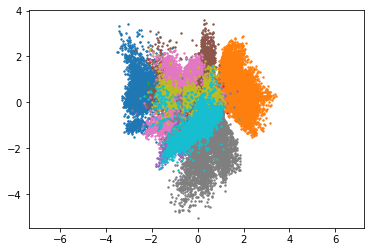

In [ ]:
for k in range(10):
  cur_data = train_images[train_labels[:, k] == True, :]
  # extract mean from trained recognition net
  transformed = recognition_net(recognition_params, cur_data)[0]
  plt.scatter(transformed[:, 0], transformed[:, 1], s=2)

plt.axis("equal")

2.3) [10 pts] Now we'll fit a model with a larger latent space.  We won't be able to visualize this model as easily, but it should be able to fit the data better.  Set latent_dimension to 20 and re-fit the model.  You should be able to get a much better ELBO using this larger model.

In [ ]:
latent_dimension = 20
# Feel free to copy code from above.

# ==========================================
# Define a specific VAE for MNIST

data_dimension = 28*28
key = random.PRNGKey(0)

# Define the recognition network.
# We implement the functions as a split output of a 1-layer MLP
# https://github.com/google/jax/blob/master/jax/experimental/README.md#neural-net-building-with-stax
init_recognize, recognition_net = serial(
    Dense(150),
    Relu,
    Dense(50),
    Relu,
    FanOut(2),
    parallel(
        Dense(latent_dimension),   # Output mean of q(z)
        Dense(latent_dimension)    # Output log_std of q(z)
        )
    )
_, init_recognition_params = init_recognize(rng, input_shape=(data_dimension,)) 


# Define the decoder network.
init_decoder, decoder = serial(
    Dense(150),
    Relu,
    Dense(50),
    Relu,
    Dense(data_dimension),    # Output logit of Ber(x|z)
)
_, init_decoder_params = init_decoder(rng, input_shape=(latent_dimension,))


# Set up log likelihood function.
def bernoulli_logpdf(logits, x):
  """Bernoulli log pdf of data x given logits."""
  return -np.sum(np.logaddexp(0., np.where(x, -1., 1.) * logits))

def log_likelihood(decoder_params, latent, datapoint): 
  logits = decoder(decoder_params, latent)
  return bernoulli_logpdf(logits, datapoint)

def log_joint(decoder_params, latent, datapoint):
  return log_prior(latent) + log_likelihood(decoder_params, latent, datapoint)

# Run optimization
optimizer=optimizers.adam
optimizer_kwargs=dict(step_size=1e-2)
n_iters = 5000
minibatch_size = 200

opt_init, opt_update, get_params = optimizer(**optimizer_kwargs)
opt_state = opt_init((init_recognition_params, init_decoder_params))

def objective(params, t):  # The loss function to be minimized.  
  rng = random.PRNGKey(t)
  minibatch_ixs = random.choice(rng, train_images.shape[0], (minibatch_size,))
  minibatch = train_images[minibatch_ixs, :]
  recognition_params, decoder_params = params
  return -batch_elbo(
    recognition_net,
    log_joint,
    recognition_params,  # a.k.a. phi
    decoder_params,      # a.k.a. theta
    minibatch,
    rng)

def callback(params, t):
  if t % 100 == 0:
    print("Iteration {} lower bound {}".format(t, -objective(params, t)))

@jit
def update(i, opt_state):
    params = get_params(opt_state) 
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)

recognition_params, decoder_params = params

Optimizing variational parameters...


  0%|          | 0/5000 [00:00<?, ?it/s]

Iteration 0 lower bound -527.3514404296875
Iteration 100 lower bound -187.71890258789062
Iteration 200 lower bound -173.259765625
Iteration 300 lower bound -155.92662048339844
Iteration 400 lower bound -151.52902221679688
Iteration 500 lower bound -144.20367431640625
Iteration 600 lower bound -135.185791015625
Iteration 700 lower bound -140.15843200683594
Iteration 800 lower bound -133.8705291748047
Iteration 900 lower bound -129.98036193847656
Iteration 1000 lower bound -134.75917053222656
Iteration 1100 lower bound -134.21424865722656
Iteration 1200 lower bound -131.71640014648438
Iteration 1300 lower bound -132.95684814453125
Iteration 1400 lower bound -129.4052276611328
Iteration 1500 lower bound -129.94439697265625
Iteration 1600 lower bound -130.73541259765625
Iteration 1700 lower bound -134.3209991455078
Iteration 1800 lower bound -130.66909790039062
Iteration 1900 lower bound -131.14146423339844
Iteration 2000 lower bound -134.3253631591797
Iteration 2100 lower bound -126.75893

(-0.31643655002117155,
 0.4940719217061996,
 -0.31682921648025514,
 0.24859012365341188)

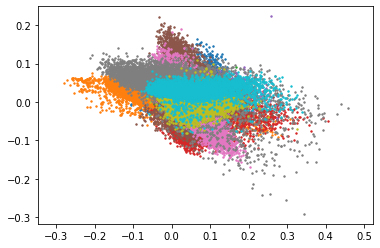

In [ ]:
for k in range(10):
  cur_data = train_images[train_labels[:, k] == True, :]
  # extract mean from trained recognition net
  transformed = recognition_net(recognition_params, cur_data)[0]
  plt.scatter(transformed[:, 0], transformed[:, 1], s=2)

plt.axis("equal")

**2.4) [5pts]** Implement the missing lines in the below code, to plot the transformed data points in the latent space.

You will be using ancestral sampling:	

1.   First sample a z from the prior.
2.   Use the generative model to compute the bernoulli means over the pixels of $x$ given $z$. 
3.   Plot these means (parameters) as a greyscale image.

Do this for 25 samples z from the prior.

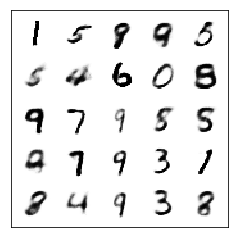

In [ ]:
# Sample data from the trained generative model to see if it
# roughly matches the data.

def sigmoid(x):
  # Maps logits to probabilities.
  return 0.5 * (np.tanh(x) + 1.0)

recognition_params, decoder_params = params

sampled_zs = jax.random.normal(rng, shape=(25, 20))
vdecoder = vmap(decoder, in_axes=(None, 0))
bernoulli_means = sigmoid(vdecoder(decoder_params, sampled_zs))
plot_images(bernoulli_means)

**2.5) [5pts]** Another way to examine a latent variable model with continuous latent variables is to interpolate between the latent representations of two points. Here we will encode 3 pairs of data points with different classes. Then we will linearly interpolate between the mean vectors of their encodings. We will plot the generative distributions along the linear interpolation.


1.   First, write a function which takes two points $z_a$ and $z_b$, and a value $\alpha \in [0,1]$, and outputs the linear interpolation $z_\alpha = \alpha z_a + (1-\alpha)z_b$.
2.  Sample 3 pairs of images, each having a different class.
3.  Encode the data in each pair, and take the mean vectors
4.  Linearly interpolate between these mean vectors
5.  At 10 equally-space points along the interpolation, plot the Bernoulli means $p(x|z_\alpha)$.
6.  Concatenate these plots into one figure.

In [ ]:
def linear_interpolation(z_a, z_b, a):
  return a*z_a + (1-a)*z_b

def plot_interp(ix1, ix2):
  left_z = recognition_net(recognition_params, train_images[ix1, :])[0]
  right_z = recognition_net(recognition_params, train_images[ix2, :])[0]
  interp_weights = list(np.linspace(0.0, 1.0, 10))
  bernoulli_means = []
  for i in range(10):
    interp_zs = linear_interpolation(left_z, right_z, interp_weights[i])
    bernoulli_means.append(sigmoid(decoder(decoder_params, interp_zs)))
  plot_images(np.array(bernoulli_means))

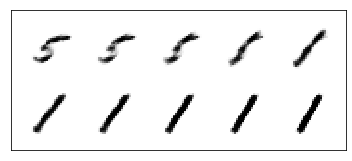

In [ ]:
plot_interp(3, 11)

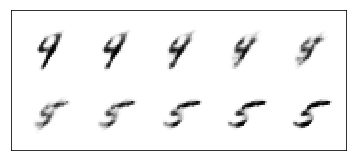

In [ ]:
plot_interp(11, 22)

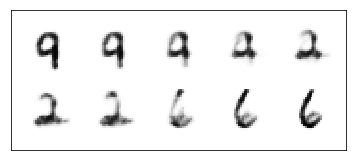

In [ ]:
plot_interp(32, 334)

# Question 3: Predicting the Bottom of Images given the Top [15 points]

Now we'll use the trained generative model to perform inference for $p(z|\text{top half of image x})$.
Unfortunately, we can't re-use our recognition network, since it can only input entire images.
However, we can still do approximate inference without the encoder.

To illustrate this, we'll approximately infer the distribution over the pixels in the bottom half an image conditioned on the top half of the image:
$$p(\text{bottom half of image x} | \text{top half of image x}) = \int p(\text{bottom half of image x} | z) p( z | \text{top half of image x}) dz$$
To approximate the posterior $p( z | \text{top half of image x})$, we'll use stochastic variational inference.

To implement SVI again, feel free to either use your ELBO as defined above, with a recognition network that doesn't use the datapoint, or re-use your SVI code from previous assignments.


[5 points] Write a function that computes $p(z, \text{top half of image x})$
	
* First, we provided a function which returns only the top half of an array. This will be useful for plotting, as well as selecting the correct Bernoulli parameters.
* Write a function that computes $\log p(\text{top half of image x} | z)$. Hint: Given $z$, the likelihood factorizes, and all the unobserved dimensions of $x$ are leaf nodes, so can be integrated out exactly.
* Combine this likelihood with the prior to get a function that takes an x and an array of $z$s, and computes $p(z, \text{top half of image x})$ for each $z$ in the array.


Now, to approximate $p(z | \text{top half of image x})$ in a scalable way, we'll use stochastic variational inference.  For 4 digits of your choosing from the training set:

Now, to approximate $p(z | \text{top half of image x})$ in a scalable way, we'll use stochastic variational inference.  For a digit of your choosing from the training set:

* Initialize variational parameters $\phi_\mu$ and $\phi_{\log \sigma}$ for a variational distribution $q_\phi(z|\text{top half of $x$})$.
* Write a function that computes estimates the ELBO over $K$ samples $z \sim q_\phi(z|\text{top half of $x$})$.
Use $\log p(z)$, $\log p(\text{top half of $x$} | z)$, and $\log q_\phi(z|\text{top half of $x$})$.
* Optimize $\phi_\mu$ and $\phi_{\log \sigma}$ to maximize the ELBO.
* Finally, take a sample $z$ from your approximate posterior, and feed it to the decoder to find the Bernoulli means of $p( \text{bottom half of image x}|z)$.  Contatenate this greyscale image to the true top of the image.
Plot the original whole image beside it for comparison.


In [ ]:
def firsthalf(x):
  D = np.shape(x)[-1]
  return x[:(D // 2)]

def secondhalf(x):
  D = np.shape(x)[-1]
  return x[(D // 2):]

# Set up optimizer.
stepsize = 0.0001
num_samples_per_iter = 50

def infer_bottom_half(ix):
  datapoint = train_images[ix, :]

  def log_likelihood_half(latent):
    logits = decoder(decoder_params, latent)
    return bernoulli_logpdf(logits, np.concatenate([firsthalf(datapoint), 0.*firsthalf(datapoint)]))

  def log_joint_half(latent):
    return log_prior(latent) + log_likelihood_half(latent)

  def svi_elbo(logprob, rng, mean, log_std):
    # Single-sample Monte Carlo estimate of the variational lower bound.
    sample = diag_gaussian_sample(rng, mean, log_std)
    return logprob(sample) - diag_gaussian_logpdf(sample, mean, log_std)

  def batch_svi_elbo(logprob, rng, params, num_samples):
    # Average over a batch of random samples. Use the vmap function for this part.
    rngs = random.split(rng, num_samples)
    vectorized_elbo = vmap(partial(svi_elbo, logprob), in_axes=(0, None, None))
    return np.mean(vectorized_elbo(rngs, *params))

  init_mean =  np.zeros(20)
  init_std  =  np.zeros(20)
  init_params = (init_mean, init_std)
  opt_init, opt_update, get_params = optimizers.momentum(step_size=stepsize, mass=0.9)
  opt_state = opt_init(init_params)

  def objective(params, t):
    # The loss function to be minimized.
    rng = random.PRNGKey(t)
    return -batch_svi_elbo(log_joint_half, rng, params, num_samples_per_iter)

  @jit
  def update(i, opt_state):
      svi_params = get_params(opt_state) 
      gradient = grad(objective)(svi_params, i)
      return opt_update(i, gradient, opt_state)

  # Main loop.
  print("Optimizing variational parameters...")
  for t in trange(0, 100):
      opt_state = update(t, opt_state)
      svi_params = get_params(opt_state)

  (svi_mean, adsf) = svi_params

  # Plotting code.
  tophalf = np.concatenate([firsthalf(datapoint), 0.*firsthalf(datapoint)])
  decoded = sigmoid(decoder(decoder_params, svi_mean))
  combined = np.concatenate([firsthalf(datapoint), secondhalf(decoded)])
  all = np.stack([datapoint, tophalf, decoded, combined], axis=1)
  plot_images(all.T)

Optimizing variational parameters...


  0%|          | 0/100 [00:00<?, ?it/s]

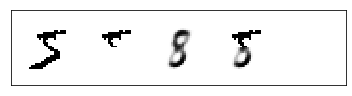

In [ ]:
infer_bottom_half(0)

Optimizing variational parameters...


  0%|          | 0/100 [00:00<?, ?it/s]

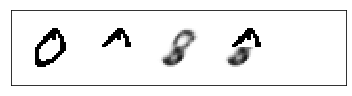

In [ ]:
infer_bottom_half(1)

Optimizing variational parameters...


  0%|          | 0/100 [00:00<?, ?it/s]

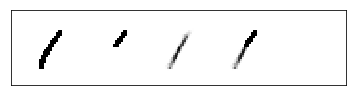

In [ ]:
infer_bottom_half(3)

Optimizing variational parameters...


  0%|          | 0/100 [00:00<?, ?it/s]

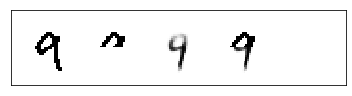

In [ ]:
infer_bottom_half(110)

# Q4 [10 points] Improving the model.

Copy code from question 2.3 or any others above that you'd like.  Try making 3 different changes to the model, recognition network, or optimization setup and report the improvement in ELBO you get for each one.


In [ ]:
# Leave a comment at the top of your code listing three changes and the improvement it made to the ELBO:
# All changes below are applied individually
# Change 1: changing the latent dimension from 20 to 10 improves the ELBO by about 10-15 units
# Change 2: doubling the dense layer size from 150 to 300 and 50 to 100 improves the ELBO by about 10-15 units
# Change 3: increasing the minibatch size from 200 to 300 improves the ELBO by about 10-15 units


In [ ]:
latent_dimension = 10
data_dimension = 28*28
key = random.PRNGKey(0)

# Define the recognition network.
# We implement the functions as a split output of a 1-layer MLP
# https://github.com/google/jax/blob/master/jax/experimental/README.md#neural-net-building-with-stax
init_recognize, recognition_net = serial(
    Dense(150),
    Relu,
    Dense(50),
    Relu,
    FanOut(2),
    parallel(
        Dense(latent_dimension),   # Output mean of q(z)
        Dense(latent_dimension)    # Output log_std of q(z)
        )
    )
_, init_recognition_params = init_recognize(rng, input_shape=(data_dimension,)) 


# Define the decoder network.
init_decoder, decoder = serial(
    Dense(150),
    Relu,
    Dense(50),
    Relu,
    Dense(data_dimension),    # Output logit of Ber(x|z)
)
_, init_decoder_params = init_decoder(rng, input_shape=(latent_dimension,))


# Set up log likelihood function.
def bernoulli_logpdf(logits, x):
  """Bernoulli log pdf of data x given logits."""
  return -np.sum(np.logaddexp(0., np.where(x, -1., 1.) * logits))

def log_likelihood(decoder_params, latent, datapoint): 
  logits = decoder(decoder_params, latent)
  return bernoulli_logpdf(logits, datapoint)

def log_joint(decoder_params, latent, datapoint):
  return log_prior(latent) + log_likelihood(decoder_params, latent, datapoint)

# Run optimization
optimizer=optimizers.adam
optimizer_kwargs=dict(step_size=1e-2)
n_iters = 5000
minibatch_size = 200

opt_init, opt_update, get_params = optimizer(**optimizer_kwargs)
opt_state = opt_init((init_recognition_params, init_decoder_params))

def objective(params, t):  # The loss function to be minimized.  
  rng = random.PRNGKey(t)
  minibatch_ixs = random.choice(rng, train_images.shape[0], (minibatch_size,))
  minibatch = train_images[minibatch_ixs, :]
  recognition_params, decoder_params = params
  return -batch_elbo(
    recognition_net,
    log_joint,
    recognition_params,  # a.k.a. phi
    decoder_params,      # a.k.a. theta
    minibatch,
    rng)

def callback(params, t):
  if t % 100 == 0:
    print("Iteration {} lower bound {}".format(t, -objective(params, t)))

@jit
def update(i, opt_state):
    params = get_params(opt_state) 
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)

recognition_params, decoder_params = params

Optimizing variational parameters...


  0%|          | 0/5000 [00:00<?, ?it/s]

Iteration 0 lower bound -528.8753051757812
Iteration 100 lower bound -196.99612426757812
Iteration 200 lower bound -171.1195526123047
Iteration 300 lower bound -142.63101196289062
Iteration 400 lower bound -136.09983825683594
Iteration 500 lower bound -128.41690063476562
Iteration 600 lower bound -121.74354553222656
Iteration 700 lower bound -127.04241943359375
Iteration 800 lower bound -123.9559555053711
Iteration 900 lower bound -120.0302963256836
Iteration 1000 lower bound -123.48139190673828
Iteration 1100 lower bound -123.04562377929688
Iteration 1200 lower bound -119.0140609741211
Iteration 1300 lower bound -120.86814880371094
Iteration 1400 lower bound -117.27252960205078
Iteration 1500 lower bound -119.08110809326172
Iteration 1600 lower bound -118.78573608398438
Iteration 1700 lower bound -121.15866088867188
Iteration 1800 lower bound -119.97347259521484
Iteration 1900 lower bound -117.9679946899414
Iteration 2000 lower bound -119.92951202392578
Iteration 2100 lower bound -115

In [ ]:
latent_dimension = 20
data_dimension = 28*28
key = random.PRNGKey(0)

# Define the recognition network.
# We implement the functions as a split output of a 1-layer MLP
# https://github.com/google/jax/blob/master/jax/experimental/README.md#neural-net-building-with-stax
init_recognize, recognition_net = serial(
    Dense(300),
    Relu,
    Dense(100),
    Relu,
    FanOut(2),
    parallel(
        Dense(latent_dimension),   # Output mean of q(z)
        Dense(latent_dimension)    # Output log_std of q(z)
        )
    )
_, init_recognition_params = init_recognize(rng, input_shape=(data_dimension,)) 


# Define the decoder network.
init_decoder, decoder = serial(
    Dense(300),
    Relu,
    Dense(100),
    Relu,
    Dense(data_dimension),    # Output logit of Ber(x|z)
)
_, init_decoder_params = init_decoder(rng, input_shape=(latent_dimension,))


# Set up log likelihood function.
def bernoulli_logpdf(logits, x):
  """Bernoulli log pdf of data x given logits."""
  return -np.sum(np.logaddexp(0., np.where(x, -1., 1.) * logits))

def log_likelihood(decoder_params, latent, datapoint): 
  logits = decoder(decoder_params, latent)
  return bernoulli_logpdf(logits, datapoint)

def log_joint(decoder_params, latent, datapoint):
  return log_prior(latent) + log_likelihood(decoder_params, latent, datapoint)

# Run optimization
optimizer=optimizers.adam
optimizer_kwargs=dict(step_size=1e-2)
n_iters = 5000
minibatch_size = 200

opt_init, opt_update, get_params = optimizer(**optimizer_kwargs)
opt_state = opt_init((init_recognition_params, init_decoder_params))

def objective(params, t):  # The loss function to be minimized.  
  rng = random.PRNGKey(t)
  minibatch_ixs = random.choice(rng, train_images.shape[0], (minibatch_size,))
  minibatch = train_images[minibatch_ixs, :]
  recognition_params, decoder_params = params
  return -batch_elbo(
    recognition_net,
    log_joint,
    recognition_params,  # a.k.a. phi
    decoder_params,      # a.k.a. theta
    minibatch,
    rng)

def callback(params, t):
  if t % 100 == 0:
    print("Iteration {} lower bound {}".format(t, -objective(params, t)))

@jit
def update(i, opt_state):
    params = get_params(opt_state) 
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)

recognition_params, decoder_params = params

Optimizing variational parameters...


  0%|          | 0/5000 [00:00<?, ?it/s]

Iteration 0 lower bound -496.1275939941406
Iteration 100 lower bound -182.91998291015625
Iteration 200 lower bound -157.5066375732422
Iteration 300 lower bound -130.6886749267578
Iteration 400 lower bound -128.42320251464844
Iteration 500 lower bound -125.25102996826172
Iteration 600 lower bound -119.83063507080078
Iteration 700 lower bound -125.07382202148438
Iteration 800 lower bound -123.16317749023438
Iteration 900 lower bound -121.33078002929688
Iteration 1000 lower bound -122.98153686523438
Iteration 1100 lower bound -121.7362060546875
Iteration 1200 lower bound -121.81187438964844
Iteration 1300 lower bound -122.18244171142578
Iteration 1400 lower bound -117.71854400634766
Iteration 1500 lower bound -120.76505279541016
Iteration 1600 lower bound -120.57626342773438
Iteration 1700 lower bound -123.06110382080078
Iteration 1800 lower bound -120.89495086669922
Iteration 1900 lower bound -119.63345336914062
Iteration 2000 lower bound -123.14588928222656
Iteration 2100 lower bound -1

In [ ]:
latent_dimension = 20
data_dimension = 28*28
key = random.PRNGKey(0)

# Define the recognition network.
# We implement the functions as a split output of a 1-layer MLP
# https://github.com/google/jax/blob/master/jax/experimental/README.md#neural-net-building-with-stax
init_recognize, recognition_net = serial(
    Dense(150),
    Relu,
    Dense(50),
    Relu,
    FanOut(2),
    parallel(
        Dense(latent_dimension),   # Output mean of q(z)
        Dense(latent_dimension)    # Output log_std of q(z)
        )
    )
_, init_recognition_params = init_recognize(rng, input_shape=(data_dimension,)) 


# Define the decoder network.
init_decoder, decoder = serial(
    Dense(150),
    Relu,
    Dense(50),
    Relu,
    Dense(data_dimension),    # Output logit of Ber(x|z)
)
_, init_decoder_params = init_decoder(rng, input_shape=(latent_dimension,))


# Set up log likelihood function.
def bernoulli_logpdf(logits, x):
  """Bernoulli log pdf of data x given logits."""
  return -np.sum(np.logaddexp(0., np.where(x, -1., 1.) * logits))

def log_likelihood(decoder_params, latent, datapoint): 
  logits = decoder(decoder_params, latent)
  return bernoulli_logpdf(logits, datapoint)

def log_joint(decoder_params, latent, datapoint):
  return log_prior(latent) + log_likelihood(decoder_params, latent, datapoint)

# Run optimization
optimizer=optimizers.adam
optimizer_kwargs=dict(step_size=1e-2)
n_iters = 5000
minibatch_size = 300

opt_init, opt_update, get_params = optimizer(**optimizer_kwargs)
opt_state = opt_init((init_recognition_params, init_decoder_params))

def objective(params, t):  # The loss function to be minimized.  
  rng = random.PRNGKey(t)
  minibatch_ixs = random.choice(rng, train_images.shape[0], (minibatch_size,))
  minibatch = train_images[minibatch_ixs, :]
  recognition_params, decoder_params = params
  return -batch_elbo(
    recognition_net,
    log_joint,
    recognition_params,  # a.k.a. phi
    decoder_params,      # a.k.a. theta
    minibatch,
    rng)

def callback(params, t):
  if t % 100 == 0:
    print("Iteration {} lower bound {}".format(t, -objective(params, t)))

@jit
def update(i, opt_state):
    params = get_params(opt_state) 
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)

recognition_params, decoder_params = params

Optimizing variational parameters...


  0%|          | 0/5000 [00:00<?, ?it/s]

Iteration 0 lower bound -525.4323120117188
Iteration 100 lower bound -199.2994384765625
Iteration 200 lower bound -172.5126953125
Iteration 300 lower bound -151.71530151367188
Iteration 400 lower bound -142.36997985839844
Iteration 500 lower bound -137.20957946777344
Iteration 600 lower bound -130.6092529296875
Iteration 700 lower bound -125.7096939086914
Iteration 800 lower bound -119.17395782470703
Iteration 900 lower bound -127.01140594482422
Iteration 1000 lower bound -119.51661682128906
Iteration 1100 lower bound -121.17218780517578
Iteration 1200 lower bound -118.69674682617188
Iteration 1300 lower bound -118.3768539428711
Iteration 1400 lower bound -116.43838500976562
Iteration 1500 lower bound -117.4429702758789
Iteration 1600 lower bound -116.56391143798828
Iteration 1700 lower bound -118.41768646240234
Iteration 1800 lower bound -117.85842895507812
Iteration 1900 lower bound -119.15937805175781
Iteration 2000 lower bound -115.15260314941406
Iteration 2100 lower bound -117.211

# Q5

Please fill out the course evaluations. We would appreciate your feedback on the course materials, assignments, structure, delivery etc.